In [411]:
from numpy.random import seed
seed(12)

import tensorflow as tf
tf.random.set_seed(12)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import numpy as np 
from statistics import mean, stdev

In [132]:
def get_data():
    (train_xf, train_yf), (test_xf, test_yf) = mnist.load_data()
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    removed = [] 
    
    for i in range(10):
        train_idx = np.where(train_yf == i)[0][0]
        train_x.append(train_xf[train_idx])
        train_y.append(train_yf[train_idx])
        removed.append(train_idx)
        
        test_idx = np.where(test_yf == i)[0][0:100]
        test_x.extend(test_xf[test_idx])
        test_y.extend(test_yf[test_idx])
            
    train_x = np.array(train_x, dtype='float32').reshape((len(train_x),28,28,1))
    test_x = np.array(test_x, dtype='float32').reshape((len(test_x),28,28,1))
    train_x = train_x/255.0
    test_x = test_x/255.0
    
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)    
    
    unlabeled = np.delete(train_xf, removed, axis=0)
    unlabeled = unlabeled.reshape((unlabeled.shape[0],28,28,1))
    unlabeled = unlabeled/255.0
    
    return train_x, train_y, test_x, test_y, unlabeled
   
    
def get_model(): 
    model = keras.Sequential()
    model.add(layers.Conv2D(24,(3,3),activation='relu',input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units=50, activation='relu'))
    model.add(layers.Dense(units=10, activation = 'softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model    

In [133]:
train_x, train_y, test_x, test_y, unlabeled = get_data()
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(10, 28, 28, 1)
(10, 10)
(1000, 28, 28, 1)
(1000, 10)


In [330]:
model_baseline = get_model()

base_log = model_baseline.fit(train_x, train_y,
                  batch_size = 1,
                  epochs = 10, 
                  shuffle=True,                
                  verbose = 1)

base_score = model_baseline.evaluate(test_x,test_y)
print("Baseline Loss: " + str(base_score[0]))
print("Baseline Accuracy: " + str(base_score[1]))

Epoch 1/10
10/10 [==============================] - 0s 1ms/step - loss: 3.8913 - accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 2.2711 - accuracy: 0.3000
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 2.2351 - accuracy: 0.4000
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 1.9973 - accuracy: 0.6000
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 1.2448 - accuracy: 0.7000
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4801 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0726 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 10/10
32/32 [==============================] - 0s 1ms/step - loss: 2.6479 - accuracy: 0.3860
Baseline Loss: 

In [417]:
stats = [] 

for i in range(10):
    model = get_model()
    model.fit(train_x, train_y,
              batch_size = 1,
              epochs = 10, 
              shuffle=True,                
              verbose = 0)
    stats.append(model.evaluate(test_x,test_y, verbose=0)[1])

print(stats)
print("Average accuracy over 10 runs: " + str(mean(stats)) + " Std: " + str(stdev(stats))) 

[0.34599998593330383, 0.33000001311302185, 0.25699999928474426, 0.3840000033378601, 0.42800000309944153, 0.3190000057220459, 0.3709999918937683, 0.34299999475479126, 0.27399998903274536, 0.4189999997615814]
Average accuracy over 10 runs: 0.3470999985933304 Std: 0.05598501918894285


In [451]:
def train_semi_supervised(model, train_x, train_y, unlabeled, n_epochs, warmup, n_labeled, n_soft, verbose=1):
    n_batches = int(train_x.shape[0]/n_labeled)

    for i in range(n_epochs): 
        idx_labeled = np.random.permutation(train_x.shape[0])
        idx_unlabeled = np.random.permutation(unlabeled.shape[0])
        loss_epoch = []
        
        soft_x = []
        soft_y = []
        if i >= warmup:
            idx_soft = idx_unlabeled[0:n_batches*n_soft]
            soft_x = unlabeled[idx_soft]
            soft_y = model.predict(soft_x)
            
        u_start = 0
        for j in range(0, train_x.shape[0], n_labeled):
            idx_lbatch = idx_labeled[j:j+n_labeled]
            batch_x = train_x[idx_lbatch]
            batch_y = train_y[idx_lbatch]
            
            
            if i >= warmup:
                batch_x = np.vstack((batch_x,soft_x[u_start:u_start+n_soft]))
                batch_y = np.vstack((batch_y,soft_y[u_start:u_start+n_soft]))
            
                u_start+=n_soft
                
            
            loss_epoch.append(model.train_on_batch(batch_x,batch_y)[0])
        
        if verbose:
            if i >= warmup:
                print("Epoch " + str(i+1) + " loss = " + str (mean(loss_epoch)) + " num soft labels = " + str(soft_y.shape[0]))
            else:
                print("Epoch " + str(i+1) + " loss = " + str (mean(loss_epoch)))
    
    return model
            

In [453]:
model_ratio = get_model()
model_ratio = train_semi_supervised(model_ratio, train_x, train_y, unlabeled, n_epochs=10, warmup=5, n_labeled=2, n_soft=3)

score = model_ratio.evaluate(test_x,test_y)
print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))

Epoch 1 loss = 3.49590425491333
Epoch 2 loss = 2.0847004890441894
Epoch 3 loss = 2.0914288997650146
Epoch 4 loss = 1.6732263803482055
Epoch 5 loss = 0.8123651742935181
Epoch 6 loss = 1.0073785543441773 num soft labels = 15
Epoch 7 loss = 0.9152100086212158 num soft labels = 15
Epoch 8 loss = 0.7395816922187806 num soft labels = 15
Epoch 9 loss = 0.5468575894832611 num soft labels = 15
Epoch 10 loss = 0.5464791834354401 num soft labels = 15
32/32 [==============================] - 0s 1ms/step - loss: 2.3923 - accuracy: 0.4020
Loss: 2.392266035079956
Accuracy: 0.4020000100135803


In [454]:
stats = [] 

for i in range(10):
    model = get_model()
    model = train_semi_supervised(model, train_x, train_y, unlabeled, n_epochs=10, warmup=5, n_labeled=2, n_soft=3, verbose=0)
    stats.append(model.evaluate(test_x,test_y, verbose=0)[1])

print(stats)
print("Average accuracy over 10 runs: " + str(mean(stats)) + " Std: " + str(stdev(stats))) 

[0.42100000381469727, 0.42100000381469727, 0.3179999887943268, 0.35100001096725464, 0.367000013589859, 0.32899999618530273, 0.4099999964237213, 0.3889999985694885, 0.3790000081062317, 0.3190000057220459]
Average accuracy over 10 runs: 0.3704000025987625 Std: 0.04027461422549332


In [455]:
def train_semi_supervised_with_threshold(model, train_x, train_y, unlabeled, n_epochs, warmup, n_labeled, max_soft, thresh = 0.7, verbose = 1):
    n_batches = int(train_x.shape[0]/n_labeled) 
         
    for i in range(n_epochs): 
        idx_labeled = np.random.permutation(train_x.shape[0])
        idx_unlabeled = np.random.permutation(unlabeled.shape[0])
        loss_epoch = []
        
        soft_x = []
        soft_y = []
        n_soft = 0
        if i >= warmup:
            idx_soft = idx_unlabeled[0:n_batches*max_soft]
            soft_x = unlabeled[idx_soft]
            soft_y = model.predict(soft_x)

            for j in range(soft_y.shape[0]-1,0,-1):
                max_idx = np.argmax(soft_y[j])
                if soft_y[j][max_idx] < thresh: 
                    soft_x = np.delete(soft_x, j, axis=0)
                    soft_y = np.delete(soft_y, j, axis=0)
                    
            n_soft = int(soft_y.shape[0]/n_batches)                
                    
            
        u_start = 0
        for j in range(0, train_x.shape[0], n_labeled):
            idx_lbatch = idx_labeled[j:j+n_labeled]
            batch_x = train_x[idx_lbatch]
            batch_y = train_y[idx_lbatch]
            
            
            if i >= warmup and soft_y.shape[0] > 0:
                batch_x = np.vstack((batch_x,soft_x[u_start:u_start+n_soft]))
                batch_y = np.vstack((batch_y,soft_y[u_start:u_start+n_soft]))
                u_start+=n_soft
                
            
            loss_epoch.append(model.train_on_batch(batch_x,batch_y)[0])
        
        if verbose:
            if i >= warmup:
                print("Epoch " + str(i+1) + " loss = " + str (mean(loss_epoch)) + " num soft labels = " + str(soft_y.shape[0]))
            else:
                print("Epoch " + str(i+1) + " loss = " + str (mean(loss_epoch)))
    
    return model

In [456]:
model_thresh = get_model()
model_thresh = train_semi_supervised_with_threshold(model_thresh, train_x, train_y, unlabeled, 
                                                    n_epochs=15, warmup=5, n_labeled=2, max_soft=5)

thresh_score = model_thresh.evaluate(test_x,test_y)

Epoch 1 loss = 3.0067036628723143
Epoch 2 loss = 2.135382604598999
Epoch 3 loss = 1.8965614080429076
Epoch 4 loss = 1.245452618598938
Epoch 5 loss = 0.42315216809511186
Epoch 6 loss = 0.2195932887494564 num soft labels = 6
Epoch 7 loss = 0.284084795974195 num soft labels = 9
Epoch 8 loss = 0.38459505438804625 num soft labels = 16
Epoch 9 loss = 0.17222611010074615 num soft labels = 11
Epoch 10 loss = 0.29417295157909396 num soft labels = 18
Epoch 11 loss = 0.31696334332227705 num soft labels = 19
Epoch 12 loss = 0.22187330648303033 num soft labels = 14
Epoch 13 loss = 0.23231619000434875 num soft labels = 18
Epoch 14 loss = 0.2951685391366482 num soft labels = 21
Epoch 15 loss = 0.2730750322341919 num soft labels = 18
32/32 [==============================] - 0s 2ms/step - loss: 2.9644 - accuracy: 0.3910


In [458]:
stats = [] 

for i in range(10):
    model = get_model()
    model = train_semi_supervised_with_threshold(model, train_x, train_y, unlabeled, 
                                                 n_epochs=15, warmup=5, n_labeled=2, max_soft=5, thresh = 0.7, verbose=0)
    stats.append(model.evaluate(test_x,test_y, verbose=0)[1])

print(stats)
print("Average accuracy over 10 runs: " + str(mean(stats)) + " Std: " + str(stdev(stats))) 

[0.28700000047683716, 0.39100000262260437, 0.21899999678134918, 0.22200000286102295, 0.42399999499320984, 0.3490000069141388, 0.31200000643730164, 0.4449999928474426, 0.296999990940094, 0.3199999928474426]
Average accuracy over 10 runs: 0.3265999987721443 Std: 0.07700966640454228


In [230]:
def get_prediction(model, image):
    scores = model.predict(image)
    return np.argmax(scores)

1 2 2


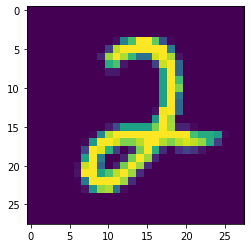

In [472]:
%matplotlib inline
import matplotlib.pyplot as plt

image = test_x[246]
pred_base = get_prediction(baseline_model,np.expand_dims(image,axis=0))
pred_ratio = get_prediction(model_ratio,np.expand_dims(image,axis=0))
pred_thresh = get_prediction(model_thresh,np.expand_dims(image,axis=0))

plt.imshow(image)
print(str(pred_base) + " " + str(pred_ratio) + " " + str(pred_thresh))